In [1]:
import json
import os
import sys
import pickle
import glob
import re
import pandas as pd
import numpy as np
from PIL import Image
from itertools import cycle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from os.path import join

# Setup

In [2]:
# paths

coco_dir = # INSERT PATH TO COCO DATASET

image_dir = join(coco_dir, 'val2014')
ann_file = join(coco_dir, 'annotations', 'captions_val2014.json')

caps_dir = '../data/generated_captions/'

cluster_path = '../data/image_clusters/image_clusters_test_3.pkl'

discriminativeness_path = '../data/results/discriminativeness_results.csv'

# which captions to include in the examples

include = [
    'coco_test_predfuse_es_d-2_l-0-5_r-na',
    'coco_test_rsa_d-2_l-na_r-1-0',
    #'coco_test_nucleus_d-na_l-na_r-na_t-0-7_p-0-7_k-na',
    'coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na',
    'coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25',
    'coco_test_beam_d-na_l-na_r-na', 'coco_test_greedy_d-na_l-na_r-na'
]

### prepare example df

In [3]:
# read files

with open(cluster_path, 'rb') as file:
    image_clusters = pickle.load(file)
    
discriminativeness_df = pd.read_csv(
    discriminativeness_path, 
    converters={
        'all_ranks': lambda x: eval(x),
        'target_positions': lambda x: eval(x),
        'image_cluster': lambda x: eval(x),
    }
)

discriminativeness_df = discriminativeness_df.rename(columns={'Unnamed: 0': 'file'})

In [4]:
# store info from filenames in df

def get_lambda(s):
    match = re.search(r'_l-(\d-\d)',s)
    if match:
        d = match.group(1).replace('-', '.')
        return float(d)
    else:
        return None
    
def get_rationality(s):
    match = re.search(r'_r-(\d-\d)',s)
    if match:
        d = match.group(1).replace('-', '.')
        return float(d)
    else:
        return None
    
def get_n_distractors(s):
    match = re.search(r'_d-(\d)',s)
    if match:
        d = match.group(1)
        return int(d)
    else:
        return None
    
def get_topk(s):
    match = re.search(r'_k-(\d+)',s)
    if match:
        d = match.group(1)
        return int(d)
    else:
        return None

def get_topp(s):
    match = re.search(r'_p-(\d-\d)',s)
    if match:
        d = match.group(1).replace('-', '.')
        return float(d)
    else:
        return None

def get_temperature(s):
    match = re.search(r'_t-(\d-\d)',s)
    if match:
        d = match.group(1).replace('-', '.')
        return float(d)
    else:
        return None    
def get_segmentation(s):
    if s.endswith('char'):
        return 'char'
    else:
        return 'word'
    
def get_method(s):
    match = re.search(r'((val)|(test))_([a-z\_]+)_d\-', s)
    if match:
        return (match.group(4))
    else:
        return None

def filename_from_id(image_id, prefix='', file_ending='.jpg'):
    """
    get image filename from id: pad image ids with zeroes,
    add file prefix and file ending
    """
    padded_ids = str(image_id).rjust(12, '0')
    filename = prefix + padded_ids + file_ending

    return (filename)

def get_image(image_id, image_dir=image_dir):
    img_path = os.path.join(
        image_dir, 
        filename_from_id(image_id, prefix='COCO_val2014_')
    )
    
    return Image.open(img_path)

def get_distractors(image_id, image_dir=image_dir, image_clusters=image_clusters):
    
    distractors = [(i[1], i[2]) for i in image_clusters  if i[0] == image_id][0]
    
    return [get_image(d) for d in distractors]    


discriminativeness_df['_lambda'] = discriminativeness_df.file.map(get_lambda)
discriminativeness_df['rationality'] = discriminativeness_df.file.map(get_rationality)
discriminativeness_df['n_distractors'] = discriminativeness_df.file.map(get_n_distractors)
discriminativeness_df['topk'] = discriminativeness_df.file.map(get_topk)
discriminativeness_df['topp'] = discriminativeness_df.file.map(get_topp)
discriminativeness_df['temperature'] = discriminativeness_df.file.map(get_temperature)
discriminativeness_df['segmentation'] = discriminativeness_df.file.map(get_segmentation)
discriminativeness_df['method'] = discriminativeness_df.file.map(get_method)

In [5]:
# sort df

methods = ['greedy', 'beam', 'topk', 'nucleus', 'predfuse_es', 'rsa']
discriminativeness_df.method = pd.Categorical(discriminativeness_df.method, categories=methods, ordered=True)

sortings = [
    ('method', True),
    ('n_distractors', True),
    ('_lambda', False),
    ('rationality', True),
    ('topp', True),
    ('topk', True),
    ('temperature', True)
]

sort_order = [s[0] for s in sortings]
ascending =  [s[1] for s in sortings]

In [6]:
# select relevant part of discriminativeness results
res_df = discriminativeness_df.loc[discriminativeness_df.n_eval_dists == 2].set_index('file')

# select relevant decoding settings
res_df = res_df.loc[include]

# sanity check
assert not False in res_df.image_cluster.map(lambda x: x == image_clusters).values

# read annotation file
with open(ann_file) as f:
    data = json.load(f)['annotations']
ann_df = pd.DataFrame(data)

In [7]:
# add model captions to dict

images = {i[0]:{} for i in image_clusters}

for file in res_df.index:
    filename = os.path.join(caps_dir, file) + '.json'
    with open(filename) as f:
        data = json.load(f)
    for entry in data:
        images[entry['image_id']].update({file:entry['caption']})
        
# add annotated captions to dict
for i in images.keys():
    images[i]['annotated'] = ann_df.loc[ann_df.image_id == i].caption.to_list()

In [8]:
# include the informativity evaluation results for each caption / setting

retrieval_results = []

for i, cluster in enumerate(image_clusters):
    r = res_df.target_positions.map(lambda x: x[i] == 0)
    retrieval_results.append(
        (r, cluster)
    )

# display examples

In [9]:
def print_image_captions(img_id, anns=images):
    print('image id:', img_id)
    print("\\begin{tabular}{ll}")

    for d in anns[img_id]:
        if d == 'annotated':
            if print_ann:
                for n,c in enumerate(anns[img_id][d]):
                    print(('annotation '+str(n)).ljust(14,'-'), c)
            else:
                pass
        else:
            print(d, '&', anns[img_id][d], '\\\\')
    print('\end{tabular}')
    
def display_target_and_distractors(cluster, save=False):
    assert len(cluster) == 3
    
    target = cluster[0]
    distractors = cluster[1:]
    
    image = get_image(target)
    distractors = [get_image(d) for d in distractors]

    # Create 2x2 sub plots
    gs = gridspec.GridSpec(2, 3)  
    gs.update(wspace=0, hspace=0.05) # set the spacing between axes. 

    fig = plt.figure(figsize=(10,6), facecolor='white')

    ax1 = plt.subplot(gs[:, :2], frame_on=True) # row 0, col 0
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    plt.imshow(image,extent=[0,100,0,1], aspect=100)

    ax2 = plt.subplot(gs[0, 2], frame_on=True) # row 0, col 1
    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])
    plt.imshow(distractors[0],extent=[0,100,0,1], aspect=100)

    ax3 = plt.subplot(gs[1, 2], frame_on=True) # row 1, span all columns
    ax3.get_xaxis().set_ticks([])
    ax3.get_yaxis().set_ticks([])
    plt.imshow(distractors[1],extent=[0,100,0,1], aspect=100)


    for ax, color in zip([ax1, ax2, ax3], ['green', 'red', 'red']):
        plt.setp(ax.spines.values(), color=color)
        plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)
        [i.set_linewidth(2) for i in [ax.spines[s] for s in ['left', 'right', 'bottom', 'top']]]    

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    if save:
        fig.savefig(str(target)+'.jpg', bbox_inches='tight')

    plt.show()
    

# tokens which are generated by ES but not greedy
# (for selecting examples)

gained_predfuse_tokens = {'above','accents','action','ad','adult','adults','airliner','airlines','alone','along','ambulance','american','among','antique','approaching','arched','arena','army','artistic','as','attire','ave','backpacks','bagel','baggage','baked','baking','balcony','balls','bamboo','barbed','barrel','bars','basketball','batch','bats','batting','beans','bearded','beautiful','beef','been','behind','bending','bent','bidet','bigger','bikers','billboard','billowing','bin','biting','blankets','blonde','blueberries','blurry','boarder','boarders','boarding','bookshelf','booth','bouquet','breakfast','brightly','bronze','brushes','buffalo','buffet','bullet','bunches','bundt','bunk','burger','burners','bushes','business','butter','cab','cabin','cabinet','caboose','cages','calico','called','camper','canal','candy','canes','canoe','capitol','capped','cardboard','cargo','carpet','celery','cellar','cellphone','ceramic','cereal','chain','chained','chandelier','chasing','checking','cheesecake','chef','chefs','chickens','chili','circus','claim','classic','cliff','climbing','closed','closet','closeup','clothes','clothing','clutter','cluttered','coast','cobblestone','color','comb','comes','competing','competition','competitive','concrete','condiments','cone','conference','construction','containers','containing','controllers','convertible','cookies','costumes','couches','countertops','countryside','course','cowboy','crate','crates','crib','crocheted','cross','crouching','crow','cruise','cub','cubicle','cubs','cupcakes','cups','curb','curled','curtains','cuts','dairy','dashboard','daughter','dead','delivery','delta','desert','desserts','device','digital','dilapidated','dinner','directing','disc','dish','dishes','dishwasher','dispensers','displayed','district','do','dolls','doors','dot','dots','drawers','drawing','dresses','driveway','dump','dusty','ear','ears','eat','eaten','elderly','electronics','empty','enclosed','engines','equipment','event','exhibit','expired','eyes','factory','faded','fake','fallen','family','fancy','farm','farmers','fashioned','father','feathers','fedex','feeder','feet','female','ferry','festival','figure','figurine','fish','fishing','five','fix','fixture','flag','flags','flatbed','flavored','flip','floors','floral','florets','flown','fluffy','fly','focus','fog','foggy','foil','folded','fondant','football','formation','forward','freezer','freight','freshly','fried','frisbees','fronts','fry','furniture','furry','galloping','games','garbage','gas','gather','gathered','gazelle','gentleman','giant','glazed','glove','glowing','golden','grabbing','granite','grapes','gravy','graze','grazes','greens','grey','grilled','grinding','grocery','gun','gym','haired','hairy','hallway','halves','ham','hammock','hang','hangar','hard','hardwood','harness','has','hats','hauling','heard','heart','helicopter','hello','herded','hero','hiding','high','hiking','holder','home','hooded','hoop','horizon','horned','horns','hotdogs','houses','how','hugging','ice','identical','image','images','industrial','instruments','interior','intersection','interstate','jars','jersey','jetliner','jets','jockeys','jungle','kettle','keyboards','keys','kick','kid','king','kissing','kiteboarding','kittens','kitty','kneeling','knees','knives','ladder','laid','lambs','lamps','landscape','lane','laps','larger','lawn','leafy','leaning','learning','led','left','lemons','library','lid','lifeguard','lift','lighted','lighthouse','like','limit','linens','lines','link','loaded','loading','loaf','locked','locomotive','low','lying','macaroni','machine','machines','made','magazines','magnets','mail','makeup','male','mall','mantle','marina','meal','meatball','medical','meeting','mens','message','milk','milking','miniature','mirrors','mobile','monk','moon','moped','motel','mother','motor','motorcyclist','motorcyclists','mountainous','muffin','mug','multiple','musical','naked','neatly','neck','necklace','neon','nest','newborn','newspaper','nightstands','nintendo','no','nose','note','notebook','number','numbers','numerals','oatmeal','office','officers','onion','onions','opened','opening','ornate','outdoor','overlooking','owl','ox','packed','pairs','pajamas','pancakes','paneled','para','parachute','parrot','passengers','past','patterned','pavement','peanut','pears','pedestal','peeled','pens','perch','perform','performing','personnel','pet','pets','pews','photograph','piano','pick','picking','pickles','pickup','pieces','piles','pineapples','pipe','pirate','pitchers','pitching','place','placing','play','plays','plunger','pocket','podium','poles','polka','porch','port','portrait','pose','poses','posted','poster','potato','powered','pregnant','presents','private','professional','propeller','protest','puddle','pulls','purse','quilt','race','racing','radishes','raft','railroad','raincoat','rainy','ram','rams','raspberries','rectangular','relaxing','remotes','resort','retriever','ride','rider','riders','rides','rings','ripe','roast','roasting','robot','rocking','roman','rotten','round','rowers','rows','runner','rural','rustic','rusty','sailboats','sailor','samsung','sandwiches','santa','sausage','savanna','scenic','scooters','sculpture','seagulls','seats','sells','serving','set','setting','several','shadow','shallow','shaped','she','sheet','shelves','shiny','ship','shirtless','shops','short','showing','showroom','shrubbery','siamese','signage','silhouette','singing','sinks','sit','site','sits','six','sized','skateboarders','skiers','skies','skirt','skyscraper','skyscrapers','slalom','sleeps','sleepy','slicing','sliding','smiles','smiley','smoking','sniffing','snowman','soaked','soap','solar','sold','soldier','someone','someones','space','speaking','spectators','speed','spoons','spots','spotted','spray','spraying','spread','square','squash','squirrel','st','stacked','stained','staircase','stairs','stairway','stalls','stands','starbucks','stars','steamed','steep','steering','stems','steps','stick','stickers','sticking','stir','stirring','stool','stoplight','stores','strapped','stream','strewn','stripe','stroller','stuck','stunt','styrofoam','sub','suburban','sugar','sunflowers','sunglasses','sunset','supplies','surfer','surrounded','sushi','swans','sweater','swimmers','tabby','tablecloth','tagged','talk','tank','tasting','taxi','taxiing','teaching','team','telephone','terminal','themed','throws','tied','tier','tiger','tile','toast','toilets','tomato','tongue','tools','toothbrushes','tops','tow','towel','towels','towers','towing','town','toys','tractor','trail','trainer','transit','transport','travel','travels','trays','tricks','triple','trolley','tropical','trunk','trying','tulips','tunnel','turn','tusks','typing','underside','uniformed','united','unmade','upside','utility','valley','vandalized','vane','vanity','vegetable','vehicle','vehicles','vending','very','vest','village','vw','walk','walkway','walled','warehouse','warning','watering','waves','weather','wheel','wicker','wig','wild','windows','wooded','wooly','worker','wrapped','writing','written','yarn','yogurt'}

search = '({})'.format('|'.join(gained_predfuse_tokens))
k = re.compile(r'(\b|^)%s(\b|$)' % search, re.I)

In [10]:
conditions = {
    'coco_test_predfuse_es_d-2_l-0-5_r-na': True, 
    'coco_test_rsa_d-2_l-na_r-1-0': True,
    #'coco_test_nucleus_d-na_l-na_r-na_t-0-7_p-0-7_k-na': False,
    'coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na': False,
    'coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25': False,
    'coco_test_beam_d-na_l-na_r-na': False,
    'coco_test_greedy_d-na_l-na_r-na': False
}

In [11]:
good_examples = [
    10428,
    482907,
    11115,
    463226,
    562628,
    262262
]

selected_results = list(filter(lambda x: x[1][0] in good_examples, retrieval_results))

[]
[]
image id: 10428
\begin{tabular}{ll}
coco_test_predfuse_es_d-2_l-0-5_r-na & a kitchen filled with lots of pictures and a clock \\
coco_test_rsa_d-2_l-na_r-1-0 & this is a picture of a room with a table and chairs \\
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na & a kitchen with a stove and wall full of different items \\
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25 & a kitchen with a sink and a mirror \\
coco_test_beam_d-na_l-na_r-na & a sink and a mirror in a room \\
coco_test_greedy_d-na_l-na_r-na & a kitchen with a sink and a mirror \\
\end{tabular}


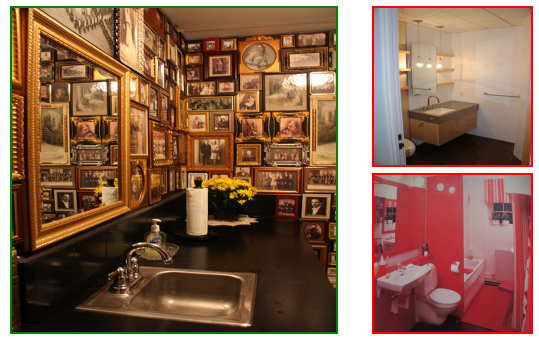

Success:
file
coco_test_predfuse_es_d-2_l-0-5_r-na                  True
coco_test_rsa_d-2_l-na_r-1-0                          True
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na     True
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25        False
coco_test_beam_d-na_l-na_r-na                        False
coco_test_greedy_d-na_l-na_r-na                      False
Name: target_positions, dtype: bool

---

[]
[]
image id: 11115
\begin{tabular}{ll}
coco_test_predfuse_es_d-2_l-0-5_r-na & a man and a woman are talking on a cell phone \\
coco_test_rsa_d-2_l-na_r-1-0 & a man and a woman are smiling for the camera \\
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na & two people are sitting together on a couch \\
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25 & a man and a woman are on a couch in a room \\
coco_test_beam_d-na_l-na_r-na & a man and a woman are sitting in a chair \\
coco_test_greedy_d-na_l-na_r-na & a man and a woman are sitting on a couch \\
\end{tabular}


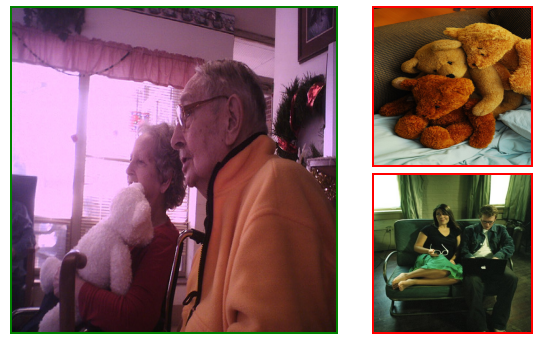

Success:
file
coco_test_predfuse_es_d-2_l-0-5_r-na                  True
coco_test_rsa_d-2_l-na_r-1-0                          True
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na    False
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25        False
coco_test_beam_d-na_l-na_r-na                        False
coco_test_greedy_d-na_l-na_r-na                      False
Name: target_positions, dtype: bool

---

[]
[]
image id: 262262
\begin{tabular}{ll}
coco_test_predfuse_es_d-2_l-0-5_r-na & a tall clock tower with trees in the background \\
coco_test_rsa_d-2_l-na_r-1-0 & a view of a tall clock tower with trees in the background \\
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na & a building that has a clock tower in the center \\
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25 & there is a very tall clock tower with a clock on it \\
coco_test_beam_d-na_l-na_r-na & a large tower with a clock on the top of it \\
coco_test_greedy_d-na_l-na_r-na & a clock tower with a clock on top of it \\
\en

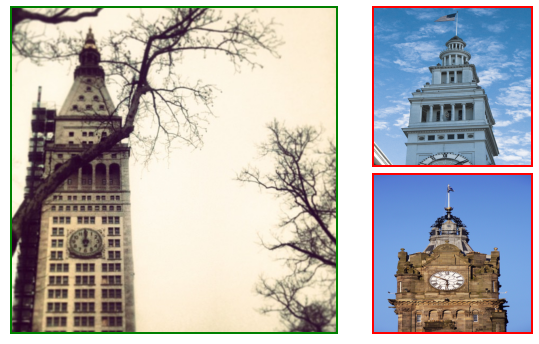

Success:
file
coco_test_predfuse_es_d-2_l-0-5_r-na                  True
coco_test_rsa_d-2_l-na_r-1-0                          True
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na    False
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25        False
coco_test_beam_d-na_l-na_r-na                        False
coco_test_greedy_d-na_l-na_r-na                      False
Name: target_positions, dtype: bool

---

[('', 'crocheted', ''), ('', 'crocheted', '')]
[('', 'yarn', '')]
image id: 463226
\begin{tabular}{ll}
coco_test_predfuse_es_d-2_l-0-5_r-na & a crocheted blanket and crocheted hat sitting on top of a blanket \\
coco_test_rsa_d-2_l-na_r-1-0 & a table topped with lots of yarn and a cake \\
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na & a pair of scissors on a blanket next to a table \\
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25 & a pair of scissors sitting on top of a counter \\
coco_test_beam_d-na_l-na_r-na & a pair of scissors sitting on top of a table \\
coco_test_greedy_d-n

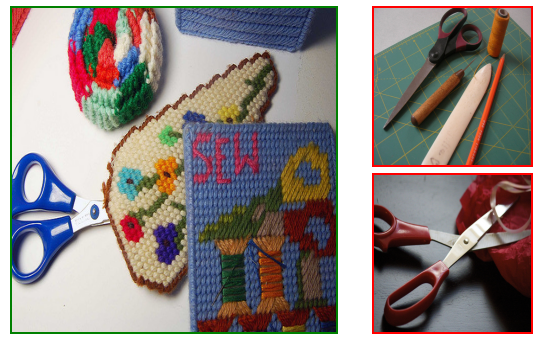

Success:
file
coco_test_predfuse_es_d-2_l-0-5_r-na                  True
coco_test_rsa_d-2_l-na_r-1-0                          True
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na    False
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25        False
coco_test_beam_d-na_l-na_r-na                        False
coco_test_greedy_d-na_l-na_r-na                      False
Name: target_positions, dtype: bool

---

[('', 'propeller', '')]
[('', 'propeller', '')]
image id: 482907
\begin{tabular}{ll}
coco_test_predfuse_es_d-2_l-0-5_r-na & an old model propeller plane flying through the air \\
coco_test_rsa_d-2_l-na_r-1-0 & a small propeller plane flying through a blue sky \\
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na & a small plane flying through a blue sky \\
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25 & a small plane flying through a blue sky \\
coco_test_beam_d-na_l-na_r-na & a small airplane flying through a blue sky \\
coco_test_greedy_d-na_l-na_r-na & a small airplane flying throu

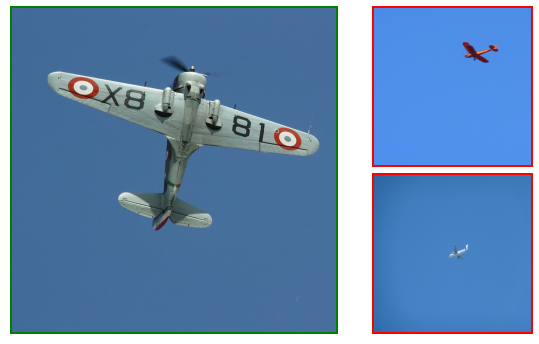

Success:
file
coco_test_predfuse_es_d-2_l-0-5_r-na                  True
coco_test_rsa_d-2_l-na_r-1-0                          True
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na    False
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25        False
coco_test_beam_d-na_l-na_r-na                        False
coco_test_greedy_d-na_l-na_r-na                      False
Name: target_positions, dtype: bool

---

[('', 'cluttered', ''), ('', 'cubicle', ''), ('', 'multiple', '')]
[('', 'office', ''), ('', 'cubicle', ''), ('', 'multiple', '')]
image id: 562628
\begin{tabular}{ll}
coco_test_predfuse_es_d-2_l-0-5_r-na & a cluttered cubicle with multiple computers and monitors \\
coco_test_rsa_d-2_l-na_r-1-0 & an office cubicle with multiple computers and monitors \\
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na & a desktop computer sitting on top of a desk \\
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25 & a desk with two computers on top of it \\
coco_test_beam_d-na_l-na_r-na & a desktop com

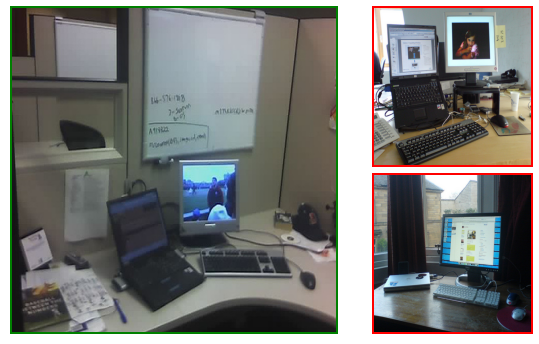

Success:
file
coco_test_predfuse_es_d-2_l-0-5_r-na                  True
coco_test_rsa_d-2_l-na_r-1-0                          True
coco_test_nucleus_d-na_l-na_r-na_t-1-0_p-0-7_k-na    False
coco_test_topk_d-na_l-na_r-na_t-0-7_p-na_k-25        False
coco_test_beam_d-na_l-na_r-na                        False
coco_test_greedy_d-na_l-na_r-na                      False
Name: target_positions, dtype: bool

---



In [12]:
print_ann = False

for s in selected_results:
    
    clstr = s[1]
    target = clstr[0]
    
    print(k.findall(images[target]['coco_test_predfuse_es_d-2_l-0-5_r-na']))
    print(k.findall(images[target]['coco_test_rsa_d-2_l-na_r-1-0']))
    print_image_captions(target)

    display_target_and_distractors(clstr, save=False)

    print('Success:')
    print(s[0])
    print('\n---\n')